In [1]:
import numpy as np
from iTEBD_TEMPO import iTEBD_TEMPO
import matplotlib.pyplot as plt
import qutip as qt

# Bath and System Paramters

The bath is a single exponential. This corresponds to the response of a single damped cavity mode.

In [2]:
G = 1
W = 1 + 1j * 1
BCF = lambda t: G * np.exp(-1j * t * W.imag - np.abs(t) * W.real)

For the system we choose a spin-$j$. The coupling operator is $S=J_z/\sqrt{j}$. The initial state is a random coherent state.

In [3]:
Delta = .05
N_c = 200
j = 1
S = qt.operators.jmat(j, 'z').full() / j
H = qt.operators.jmat(j, 'x').full() + .2 * qt.operators.jmat(j, 'y').full()
Rho_0 = qt.ket2dm(qt.spin_coherent(j, np.pi / 2 * np.random.rand(), np.pi / 2 * np.random.rand())).full()

These are the parameters for the time evolution

In [4]:
Delta = 0.1
T_max = 20
N = int(T_max / Delta)
T_eval = np.linspace(0, N * Delta, N + 1)

# Exact solution via Qutip 

We can get the exact dynamics from qutip by simulating the Markovian dynamics of the system and cavity mode.

In [5]:
NC = 20 # maximum dimension of pseudomode
NS = int(2 * j + 1)
a = qt.destroy(NC)
S1 = qt.qeye(NS)
C1 = qt.qeye(NC)
Htot = qt.tensor(qt.Qobj(H), C1) + np.sqrt(G) * (qt.tensor(qt.Qobj(S), a.dag()) + qt.tensor(qt.Qobj(S).dag(), a)) + W.imag * qt.tensor(S1, a.dag() * a)
sol_qt = qt.mesolve(Htot, qt.tensor(qt.Qobj(Rho_0), qt.ket2dm(qt.basis(NC, 0))), T_eval, [np.sqrt(W.real * 2) * qt.tensor(S1, a)], [])

# iTEBD-TEMPO

The same calculation using iTEBD-TEMPO. Initially one has to pass the eigenvalues of $S$ (this operator must be diagonal), the time step $\Delta$, the bath correlation function, and the number of memory time steps $N_c$.

In [6]:
MyiTEBD_TEMPO = iTEBD_TEMPO(np.diagonal(S), Delta, BCF, 1000)

This computes the influence functional using iTEBD.

In [7]:
MyiTEBD_TEMPO.compute_f(rank=100, rtol=1e-6)

building influence functional: 100%|███████████| 1000/1000 [00:00<00:00, 1867.84it/s]

rank  14


This function computes the time evolution for $N$ time steps for Hamiltonian $H$ and initial state $\rho_0$.

In [8]:
Rho_t = MyiTEBD_TEMPO.evolve(H, Rho_0, N)

time evolution running: 100%|████████████████████| 200/200 [00:00<00:00, 4209.01it/s]


We can also compute the steady state directly.

In [9]:
Rho_ss = MyiTEBD_TEMPO.steadystate(H)

We obtain the exact dynamics.

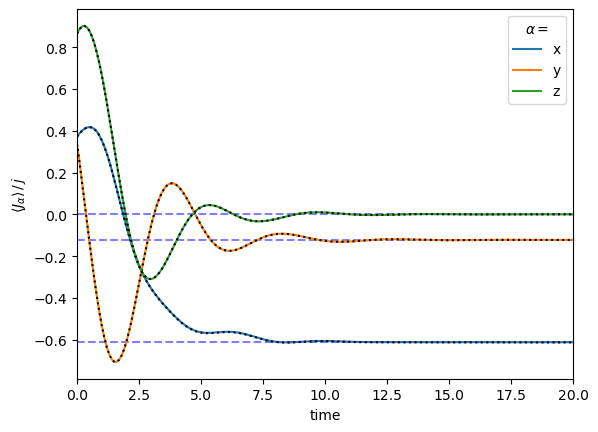

In [10]:
def expect(x, o):
    return np.einsum('ij,tji->t', o, x)

for i in ['x','y','z']:
    plt.plot(T_eval,0*T_eval+np.trace(Rho_ss @ qt.operators.jmat(j,i).full()).real / j, c='b',ls='--', alpha=.5)
    plt.plot(T_eval,expect(Rho_t, qt.operators.jmat(j,i)).real / j, label=i)
    plt.plot(T_eval,qt.expect(sol_qt.states, qt.tensor(qt.operators.jmat(j, i), C1)).real / j, c='k', ls='dotted')

plt.xlim(T_eval.min(), T_eval.max())
plt.xlabel('time')
plt.ylabel(r'$\langle J_\alpha \rangle\, /\, j$')
plt.legend(title=r'$\alpha=$')